In [1]:
import pandas as pd

In [2]:
import sys
sys.path.insert(0, "../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import torch
 
data = pd.read_csv(r"../sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [3]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [4]:
train = (data["Center"] == "Leipzig") & (data["Set"] == "Training")
test = (data["Center"] == "Leipzig") & (data["Set"] == "Validation")
val = (data["Center"] == "Greifswald") & (data["Set"] == "Validation")

In [5]:
train = torch.from_numpy(train.values)
test = torch.from_numpy(test.values)
val = torch.from_numpy(val.values)

In [6]:
import torch


X = data[FEATURES].values
y = data[LABEL_COLUMN_NAME].values

In [7]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution="normal")
scaler.fit(X[train])
X = scaler.transform(X)

In [8]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [9]:
id_grouped_data = data.groupby("Id")

In [10]:
from tqdm.notebook import tqdm

X_train_sequences = dict({})
y_train_sequences = dict({})

X_test_sequences = dict({})
y_test_sequences = dict({})

X_test_gw_sequences = dict({})
y_test_gw_sequences = dict({})

for id, data in tqdm(id_grouped_data):
    time_series_len = data.shape[0]
    is_training = (data["Set"] == "Training").all()
    is_gw_test = (data["Center"] == "Greifswald").all()
    X_sgd = torch.from_numpy(data[FEATURES].values).type(torch.float).unsqueeze(0)
    y_sgd = torch.from_numpy(data[LABEL_COLUMN_NAME].values).type(torch.float)
    if is_training:
        if time_series_len not in X_train_sequences:
            X_train_sequences[time_series_len] = []
            y_train_sequences[time_series_len] = []
        X_train_sequences[time_series_len].append(X_sgd)
        y_train_sequences[time_series_len].append(y_sgd)
    elif is_gw_test:
        if time_series_len not in X_test_gw_sequences:
            X_test_gw_sequences[time_series_len] = []
            y_test_gw_sequences[time_series_len] = []
        X_test_gw_sequences[time_series_len].append(X_sgd)
        y_test_gw_sequences[time_series_len].append(y_sgd)
    else:
        if time_series_len not in X_test_sequences:
            X_test_sequences[time_series_len] = []
            y_test_sequences[time_series_len] = []
        X_test_sequences[time_series_len].append(X_sgd)
        y_test_sequences[time_series_len].append(y_sgd)
    assert data["Set"].unique().shape[0] == 1
    assert data["Center"].unique().shape[0] == 1

  0%|          | 0/866517 [00:00<?, ?it/s]

In [11]:
import numpy as np

def get_batches(X_sequences:dict, y_sequences:dict):
    X_batches = []
    y_batches = []
    for key in tqdm(X_sequences.keys()):
        X_batch = torch.from_numpy(np.array(X_sequences[key]).squeeze(axis=1))
        y_batch = torch.from_numpy(np.array(y_sequences[key]))
    
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    return (X_batches, y_batches)

In [12]:
X_train_batches, y_train_batches = get_batches(X_train_sequences, y_train_sequences)
X_test_batches, y_test_batches = get_batches(X_test_sequences, y_test_sequences)
X_test_gw_batches, y_test_gw_batches = get_batches(X_test_gw_sequences, y_test_gw_sequences)

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [13]:
sets = dict()
sets["train"] = X_train_batches
# sets["val"] = X_times[new_val]
sets["test"] =  X_test_batches
sets["gw_test"] =  X_test_gw_batches

In [14]:
labels = dict()
labels["train"] = y_train_batches
# labels["val"] = y[new_val]
labels["test"] =  y_test_batches
labels["gw_test"] = y_test_gw_batches

In [15]:
losses = dict()
losses["train"] = []
losses["val"] = []
losses["test"] = []
losses["gw_test"] = []

In [16]:
aurocs = dict()
aurocs["train"] = []
aurocs["val"] = []
aurocs["test"] = []
aurocs["gw_test"] = []

In [17]:
counts = torch.unique(y[train], return_counts=True)[-1]
WEIGHT = counts[0] / counts[-1]
WEIGHT

tensor(664.1861)

In [57]:
from sklearn.metrics import roc_auc_score

def evaluate(model, set_name):
    global X_times, losses, labels
    with torch.inference_mode():
        model.eval()
        acc_loss = 0
        batch_size = 0
        acc_labels = []
        acc_proba = []
        
        for idx, x in enumerate(sets[set_name]):
            logits = model(x)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits.squeeze(-1), labels[set_name][idx],pos_weight=WEIGHT)
            last_proba_set = torch.sigmoid(logits.squeeze(-1))
        
            acc_labels.extend(labels[set_name][idx].view(-1).cpu().tolist())
            acc_proba.extend(last_proba_set.view(-1).cpu().tolist())
            acc_loss += loss.item()
            batch_size+= x.shape[0]
        losses[set_name].append(acc_loss/batch_size)
        print(f"Set {set_name}:\t{acc_loss}")
        auroc = roc_auc_score(np.array(acc_labels), np.array(acc_proba))
        aurocs[set_name].append(auroc)
        # print(f"{set_name} has AUROC: {auroc}")

In [89]:
def empty_dict(dictionary):
    for key in dictionary.keys():
        dictionary[key] = []

In [90]:
def transfer_dict(dictionary,device):
    for key in dictionary.keys():
        for idx in range(len(dictionary[key])):
            dictionary[key][idx] =  dictionary[key][idx].to(device)

In [91]:
device = torch.device("cpu") #torch.device("cuda:0")

In [111]:
def full_batch_epoch(model):
    global X_times, y, sets
    model.train()
    optim.zero_grad()
    acc_loss = 0
    
    for idx, x in enumerate(sets["train"]):
        logits = model(x)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits.squeeze(-1), labels["train"][idx],pos_weight=WEIGHT)
        acc_loss+= loss.item()
        loss.backward()
        if idx >= 2:
            break
    for set_name in sets:
        evaluate(model, set_name)
    optim.step()
    return acc_loss

In [112]:
from torch import nn
from torch.autograd import Variable 

class TimeTransformer(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size,dropout, layers, heads, dim_feedforward, project):
        super(TimeTransformer, self).__init__()
        self.num_classes = num_classes #number of classes
        self.input_size = input_size #input size
        self.hidden_size = hidden_size if project else input_size #hidden_size #hidden state
        self.num_layers = layers
        self.dropout = dropout
        self.project = project

        self.linear = nn.Linear(self.input_size, self.hidden_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=heads, dim_feedforward = dim_feedforward, dropout = self.dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.num_layers, enable_nested_tensor =True)
        self.fc_1 =  nn.Linear(self.hidden_size, 1) #fully connected 1

        self.relu = nn.ReLU()
    
    def forward(self,x):
        # Propagate input through LSTM
        if self.project:
            x = self.linear(x)
            x = self.relu(x)
        output = self.transformer(x)
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        return out#output[:,-1,0] #out

In [115]:
from tqdm.notebook import tqdm
import time

is_continue = False #True
if not is_continue:
    model = TimeTransformer(num_classes=1, input_size=X.shape[1],\
                            hidden_size=8, dropout=0.0,\
                            layers=1, heads=2, dim_feedforward=16, project=True).to(device) 
    transfer_dict(sets, device)
    transfer_dict(labels, device)
    empty_dict(losses)
    empty_dict(aurocs)
    lr = .001# 1e-4
    weight_decay = 0 #1e-4
    optim = torch.optim.Adam(params=model.parameters(), lr = lr, weight_decay=weight_decay)

patience = 30
epochs = 60
##TODO step by step and shape evaluation in epoch
for epoch in tqdm(range(epochs)):
    print(epoch)
    start = time.time()
    loss = full_batch_epoch(model)
    # if epoch == 20:
    #     for g in optim.param_groups:
    #         g['lr'] = 0.0001
    if len(losses["val"]) > patience and all(list(map(lambda l: l<=losses["val"][-1], losses["val"][-patience-1:]))):
        break

  0%|          | 0/60 [00:00<?, ?it/s]

0
Set train:	196.40478360652924
Set test:	111.43869692087173
Set gw_test:	102.17621088027954
1
Set train:	196.13088089227676
Set test:	111.24901932477951
Set gw_test:	101.78358846902847
2
Set train:	195.79589641094208
Set test:	111.01128900051117
Set gw_test:	101.43606352806091
3
Set train:	195.42981094121933
Set test:	110.7543488740921
Set gw_test:	101.08934813737869
4
Set train:	195.0674371123314
Set test:	110.49973958730698
Set gw_test:	100.75365394353867
5
Set train:	194.71005648374557
Set test:	110.25733709335327
Set gw_test:	100.43144583702087
6
Set train:	194.35161638259888
Set test:	110.02463179826736
Set gw_test:	100.11184585094452
7
Set train:	193.96179521083832
Set test:	109.79298949241638
Set gw_test:	99.7994527220726
8
Set train:	193.5856157541275
Set test:	109.56174147129059
Set gw_test:	99.53292661905289
9
Set train:	193.20482939481735
Set test:	109.34878933429718
Set gw_test:	99.233154296875
10
Set train:	192.8023166656494
Set test:	109.15082621574402
Set gw_test:	98.92

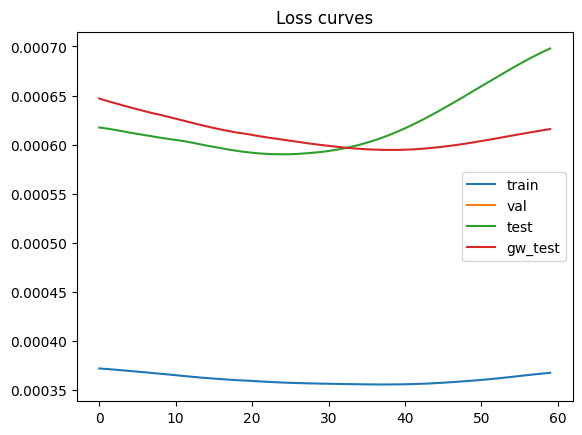

In [116]:
import matplotlib.pyplot as plt

for set_name in losses:
    plt.plot(losses[set_name])
plt.legend(losses.keys())
plt.title("Loss curves")
plt.show()

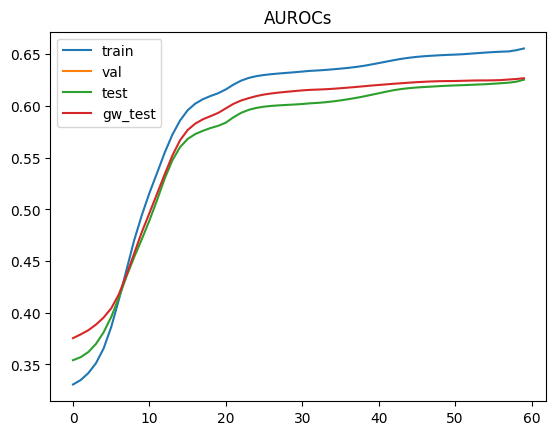

In [117]:
import matplotlib.pyplot as plt

for set_name in aurocs:
    plt.plot(aurocs[set_name])
plt.legend(aurocs.keys())
plt.title("AUROCs")
plt.show()

In [85]:
max(aurocs["test"])

0.47734260043541843

## Evaluate the time series equence lengths

In [307]:
id_grouped_data.size().describe()

count    866517.000000
mean          2.099711
std           3.201005
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         416.000000
dtype: float64

In [312]:
num_sampples_list =  []
for i in range(id_grouped_data.size().max()+1):
    num_samples = (id_grouped_data.size() == i).sum()
    num_sampples_list.append(num_samples)

Text(0.5, 0, 'Length of time series')

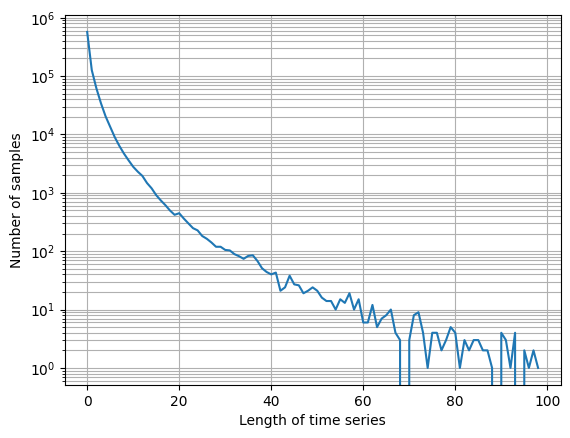

In [322]:
import matplotlib.pyplot as plt
plt.semilogy(num_sampples_list[1:100])
plt.grid(which="both")
plt.ylabel("Number of samples")
plt.xlabel("Length of time series")